# Gold price prediction using regression techniques

## importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor , GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pickle

## Data Processing 

In [2]:
gold_data = pd.read_csv('golddaily.csv')                   #reading data from dataset.csv

In [3]:
gold_data.head()

,Date,Price,Open,High,Low,Chg%
0,01-Jan-24,63320,63225,63379,63181,0.19%
1,29-Dec-23,63203,63246,63385,63051,-0.29%
2,28-Dec-23,63389,63728,63821,63333,-0.45%
3,27-Dec-23,63678,63198,63710,63179,1.04%
4,26-Dec-23,63025,63149,63198,62903,0.11%


In [4]:
# gold_data['Price'] = gold_data['Price'].int.replace(',', '').astype(float)
# gold_data['Open'] = gold_data['Open'].int.replace(',', '').astype(float)
# gold_data['High'] = gold_data['High'].int.replace(',', '').astype(float)
# gold_data['Low'] = gold_data['Low'].int.replace(',', '').astype(float)
gold_data['Chg%'] = gold_data['Chg%'].str.rstrip('%').astype(float)                       #changing datatype of change from % object to float64

In [5]:
# Convert 'Date' column to datetime format with specified format
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d-%b-%y')
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%b-%y')

# Extract Year, Month, and Day
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['Day'] = gold_data['Date'].dt.day

# Drop the original 'Date' column
gold_data.drop('Date', axis=1, inplace=True)


In [6]:
## Adding some noise for overcoming overfitting
synthetic_data = pd.DataFrame()

for column in gold_data.columns:
    # Generate synthetic data for each column
    synthetic_column = np.random.choice(gold_data[column], size=100)
    synthetic_data[column] = synthetic_column


In [7]:
merged_data = pd.concat([gold_data, synthetic_data])

In [8]:
merged_data

,Price,Open,High,Low,Chg%,Year,Month,Day
0,63320,63225,63379,63181,0.19,2024,1,1
1,63203,63246,63385,63051,-0.29,2023,12,29
2,63389,63728,63821,63333,-0.45,2023,12,28
3,63678,63198,63710,63179,1.04,2023,12,27
4,63025,63149,63198,62903,0.11,2023,12,26
...,...,...,...,...,...,...,...,...
95,25291,47647,51179,38376,-0.38,2019,5,26
96,24813,28590,29696,51320,0.69,2021,8,2
97,56741,28473,27035,39765,0.75,2021,4,17
98,25426,46711,48248,26550,-0.10,2021,11,18


In [9]:
gold_data.describe()                                         

,Price,Open,High,Low,Chg%,Year,Month,Day
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000
mean,38255.199460,38249.878472,38452.240355,38053.575617,0.034904,2018.475309,6.513889,15.719136
std,11337.916616,11337.067365,11403.420055,11272.424903,0.847437,2.884796,3.447545,8.792376
min,24597.000000,24535.000000,24701.000000,24451.000000,-8.670000,2014.000000,1.000000,1.000000
25%,28788.750000,28796.500000,28910.250000,28667.750000,-0.410000,2016.000000,4.000000,8.000000
50%,31638.000000,31633.500000,31827.000000,31513.500000,0.040000,2018.000000,7.000000,16.000000
75%,48681.000000,48691.000000,48925.750000,48465.750000,0.480000,2021.000000,9.250000,23.000000
max,63678.000000,63728.000000,64460.000000,63333.000000,5.670000,2024.000000,12.000000,31.000000


## Data Extraction

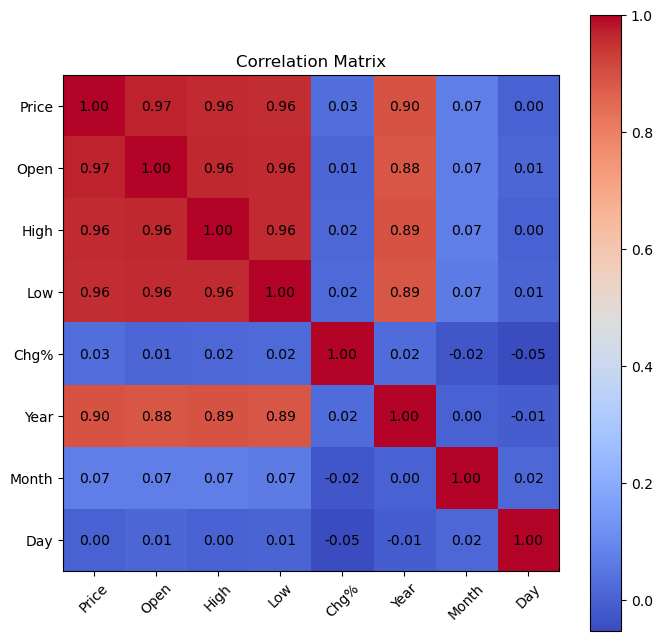

In [10]:
correlation = merged_data.corr()

plt.figure(figsize=(8, 8))
plt.title('Correlation Matrix')
plt.imshow(correlation, cmap='coolwarm', interpolation='nearest')

# Add text annotations
for i in range(len(correlation)):
    for j in range(len(correlation)):
        plt.text(j, i, f'{correlation.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.colorbar()
plt.xticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns, rotation=45)
plt.yticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns)
plt.show()

In [11]:
print(correlation)

          Price      Open      High       Low      Chg%      Year     Month  \
Price  1.000000  0.967690  0.959825  0.958477  0.031471  0.895509  0.073859   
Open   0.967690  1.000000  0.963895  0.960218  0.009172  0.884902  0.074696   
High   0.959825  0.963895  1.000000  0.959881  0.016337  0.893552  0.073612   
Low    0.958477  0.960218  0.959881  1.000000  0.017664  0.888615  0.065480   
Chg%   0.031471  0.009172  0.016337  0.017664  1.000000  0.022268 -0.024324   
Year   0.895509  0.884902  0.893552  0.888615  0.022268  1.000000  0.002661   
Month  0.073859  0.074696  0.073612  0.065480 -0.024324  0.002661  1.000000   
Day    0.001281  0.009580  0.001990  0.005306 -0.052567 -0.010704  0.017028   

            Day  
Price  0.001281  
Open   0.009580  
High   0.001990  
Low    0.005306  
Chg%  -0.052567  
Year  -0.010704  
Month  0.017028  
Day    1.000000  


In [12]:
gold_data.isnull().sum()

Price    0
Open     0
High     0
Low      0
Chg%     0
Year     0
Month    0
Day      0
dtype: int64

In [13]:
price_column = gold_data.pop('Price')
gold_data['Price'] = price_column

In [14]:
merged_data.isnull().sum()

Price    0
Open     0
High     0
Low      0
Chg%     0
Year     0
Month    0
Day      0
dtype: int64

In [15]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2592 non-null   int64  
 1   High    2592 non-null   int64  
 2   Low     2592 non-null   int64  
 3   Chg%    2592 non-null   float64
 4   Year    2592 non-null   int32  
 5   Month   2592 non-null   int32  
 6   Day     2592 non-null   int32  
 7   Price   2592 non-null   int64  
dtypes: float64(1), int32(3), int64(4)
memory usage: 131.8 KB


In [16]:
X = merged_data.drop('Price', axis=1)
Y = merged_data['Price']

In [17]:
X.tail()

,Open,High,Low,Chg%,Year,Month,Day
95,47647,51179,38376,-0.38,2019,5,26
96,28590,29696,51320,0.69,2021,8,2
97,28473,27035,39765,0.75,2021,4,17
98,46711,48248,26550,-0.10,2021,11,18
99,26934,31925,50150,0.00,2021,1,5


In [18]:
from sklearn.model_selection import train_test_split


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Standardisation

In [20]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## LINEAR REGRESSION

In [21]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, Y_train)

LinearRegression()

In [22]:
test_data_prediction = linear_regressor.predict(X_test_scaled)

In [23]:
test_data_prediction

array([29067.22446694, 26838.46760722, 51127.7235081 , 47249.80756905,
       27969.54574628, 30975.23259554, 37964.89059605, 27098.0226382 ,
       29533.16839438, 29379.3874496 , 29704.57604488, 29203.79980099,
       27826.36701038, 58203.30478819, 30876.77890369, 38648.86747384,
       28766.8042831 , 27997.05407933, 51368.68199808, 26395.03195916,
       49751.28198564, 46621.99305824, 26759.19868072, 34016.03696095,
       47245.46447733, 49108.13445165, 46686.20223737, 28943.8352346 ,
       26176.70820256, 48743.26236988, 28842.65344907, 26750.18861113,
       50235.50216758, 54548.9798009 , 46520.61731525, 49986.05303444,
       59348.37352821, 45259.07255032, 30062.97091811, 27074.37826585,
       31934.28122705, 29358.11231517, 48661.44677634, 51043.568843  ,
       27101.23714305, 38115.3430192 , 29454.88274348, 47698.67638011,
       51332.22517357, 47910.99932287, 29984.85784091, 58340.15965921,
       28964.90313414, 58385.11756202, 29753.30017177, 49782.77573983,
      

In [24]:
error_score = metrics.r2_score(Y_test, test_data_prediction)
mae_lr = mean_absolute_error(Y_test, test_data_prediction)
mse_lr = mean_squared_error(Y_test, test_data_prediction)
print("MAE (Linear Regression): {:.2f}".format(mae_lr))
print("MSE (Linear Regression): {:.2f}".format(mse_lr))
print("R squared error : ", error_score)


MAE (Linear Regression): 672.21
MSE (Linear Regression): 4766964.72
R squared error :  0.9621450296075766


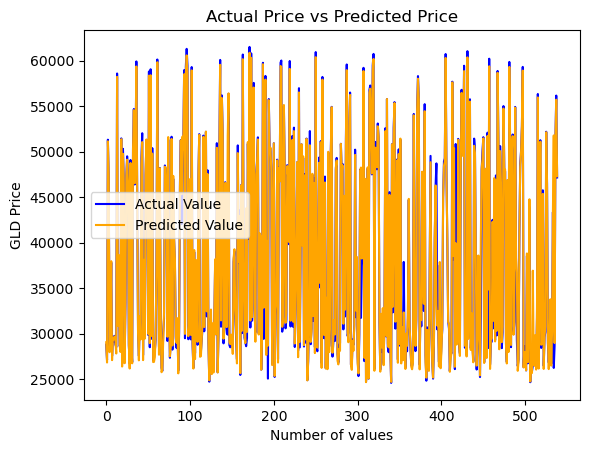

In [25]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

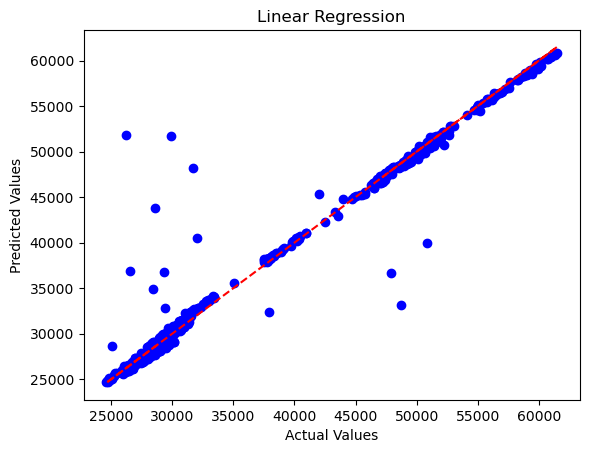

In [26]:
plt.scatter(Y_test, test_data_prediction, color='blue')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\KIIT\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


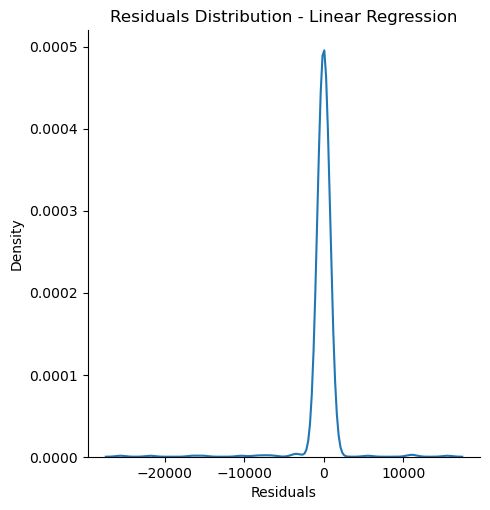

In [27]:
sns.displot(Y_test - test_data_prediction, kind='kde')
plt.title('Residuals Distribution - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [28]:
print("Accuracy of linear Regression model: {:.2f}%".format(error_score * 100))

Accuracy of linear Regression model: 96.21%


In [29]:
pickle.dump(linear_regressor,open('linear_regressor.pkl','wb'))

## RANDOM REGRESSION

In [30]:
random_regressor = RandomForestRegressor(n_estimators=100)

In [31]:
random_regressor.fit(X_train_scaled, Y_train)

RandomForestRegressor()

In [32]:
test_data_predictionR = random_regressor.predict(X_test_scaled)

In [33]:
error_scoreR = metrics.r2_score(Y_test, test_data_predictionR) #add test_data_prediction for random forest
mae_rf = mean_absolute_error(Y_test, test_data_predictionR)
mse_rf = mean_squared_error(Y_test, test_data_predictionR)
print("MAE (Random Forest Regression): {:.2f}".format(mae_rf))
print("MSE (Random Forest Regression): {:.2f}".format(mse_rf))
print("R squared error : ", error_scoreR)

MAE (Random Forest Regression): 366.51
MSE (Random Forest Regression): 3077197.25
R squared error :  0.9755636515745134


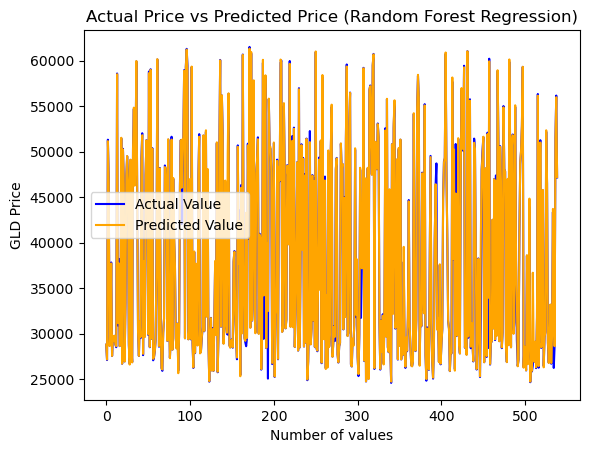

In [34]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_predictionR, color='orange', label='Predicted Value')
plt.title('Actual Price vs Predicted Price (Random Forest Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

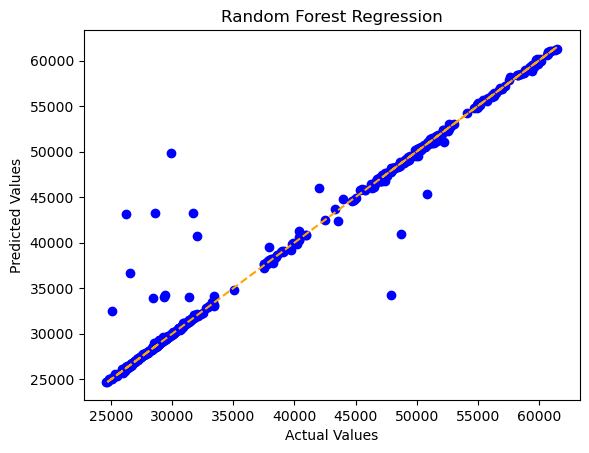

In [35]:
plt.scatter(Y_test, test_data_predictionR, color='blue')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Random Forest Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

C:\Users\KIIT\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


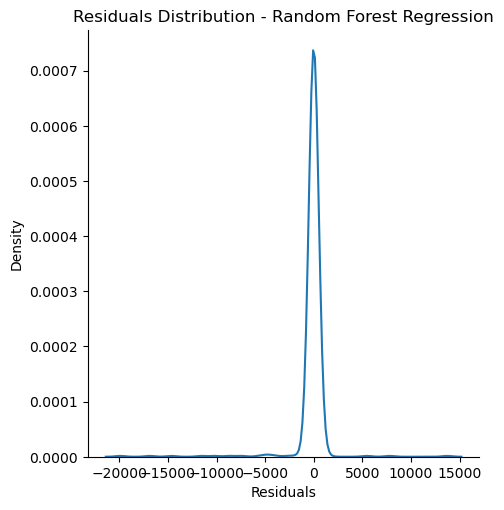

In [36]:
sns.displot(Y_test - test_data_predictionR, kind='kde')
plt.title('Residuals Distribution - Random Forest Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [37]:
print("Accuracy of random forest Regression model: {:.2f}%".format(error_scoreR * 100))

Accuracy of random forest Regression model: 97.56%


In [38]:
pickle.dump(random_regressor,open('random_regressor.pkl','wb'))

## XGBOOST

In [39]:
import xgboost as xgb
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train_scaled, Y_train)

In [ ]:
Y_pred_xgb = xgb_regressor.predict(X_test_scaled)

In [ ]:
Y_pred_xgb

In [ ]:
r2_xgb = r2_score(Y_test, Y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)
print("MAE (XGBoost Regression): {:.2f}".format(mae_xgb))
print("MSE (XGBoost Regression): {:.2f}".format(mse_xgb))
print("XGBoost Regression R squared error: ", r2_xgb)

In [ ]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_xgb, color='orange', label='Predicted Value (XGBoost)')
plt.title('Actual Price vs Predicted Price (XGBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

In [ ]:
plt.scatter(Y_test, Y_pred_xgb, color='green')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('XGBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
sns.displot(Y_test - Y_pred_xgb, kind='kde')
plt.title('Residuals Distribution - XGBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of XGBoost Regression model: {:.2f}%".format(r2_xgb * 100))

In [ ]:
pickle.dump(xgb_regressor,open('xgb_regressor.pkl','wb'))

## ADA BOOST Regression

In [ ]:
adaboost_regressor = AdaBoostRegressor()

In [ ]:
adaboost_regressor.fit(X_train_scaled, Y_train)

In [ ]:
Y_pred_adaboost = adaboost_regressor.predict(X_test_scaled)

In [ ]:
Y_pred_adaboost

In [ ]:
r2_adaboost = r2_score(Y_test, Y_pred_adaboost)
mae_adaboost = mean_absolute_error(Y_test, Y_pred_adaboost)
mse_adaboost = mean_squared_error(Y_test, Y_pred_adaboost)
print("MAE (AdaBoost Regression): {:.2f}".format(mae_adaboost))
print("MSE (AdaBoost Regression): {:.2f}".format(mse_adaboost))
print("R squared error (AdaBoost Regression):", r2_adaboost)

In [ ]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_adaboost, color='red', label='Predicted Value (AdaBoost Regression)')
plt.title('Actual Price vs Predicted Price (AdaBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

In [ ]:
plt.scatter(Y_test, Y_pred_adaboost, color='orange')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('AdaBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
sns.displot(Y_test - Y_pred_adaboost, kind='kde')
plt.title('Residuals Distribution - AdaBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of AdaBoost Regression model: {:.2f}%".format(r2_adaboost * 100))

In [ ]:
pickle.dump(adaboost_regressor,open('adaboost_regressor.pkl','wb'))

## Support Vector Machine

In [ ]:
pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from imblearn.over_sampling import RandomOverSampler

In [ ]:
svm_regressor = SVR()

In [ ]:
svm_regressor.fit(X_train_scaled, Y_train)

In [ ]:
# # Making predictions on the test data
Y_pred_svm = svm_regressor.predict(X_test_scaled)

In [ ]:
# SVM Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}  
svm_regressor = SVR()
grid_search = GridSearchCV(svm_regressor, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, Y_train)
best_params = grid_search.best_params_
print("Best Parameters for SVM:", best_params)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=7)
X_train_selected = selector.fit_transform(X_train_scaled, Y_train)
X_test_selected = selector.transform(X_test_scaled)

# SVM with best parameters
svm_regressor = SVR(**best_params)
svm_regressor.fit(X_train_selected, Y_train)
Y_pred_svm = svm_regressor.predict(X_test_selected)
r2_svm = metrics.r2_score(Y_test, Y_pred_svm)
print("Accuracy of SVM Regression model after rectifications: {:.2f}%".format(r2_svm * 100))

# Handle Data Imbalance
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train_selected, Y_train)

# SVM after handling data imbalance
svm_regressor = SVR(**best_params)
svm_regressor.fit(X_train_resampled, Y_train_resampled)
Y_pred_svm = svm_regressor.predict(X_test_selected)
r2_svm = metrics.r2_score(Y_test, Y_pred_svm)
print("Accuracy of SVM Regression model after handling data imbalance: {:.2f}%".format(r2_svm * 100))

In [ ]:
r2_svm = r2_score(Y_test, Y_pred_svm)
mae_svm = mean_absolute_error(Y_test, Y_pred_svm)
mse_svm = mean_squared_error(Y_test, Y_pred_svm)
print("MAE (SVM Regression): {:.2f}".format(mae_svm))
print("MSE (SVM Regression): {:.2f}".format(mse_svm))
print("R squared error (SVM Regression):", r2_svm)

In [ ]:
# Plotting Actual vs Predicted values
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_svm, color='red', label='Predicted Value (SVM Regression)')
plt.title('Actual Price vs Predicted Price (SVM Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

In [ ]:
plt.scatter(Y_test, Y_pred_svm, color='purple')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('SVM Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
sns.displot(Y_test - Y_pred_svm, kind='kde')
plt.title('Residuals Distribution - SVM Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of AdaBoost Regression model: {:.2f}%".format(r2_svm * 100))

In [ ]:
pickle.dump(svm_regressor,open('svm_regressor.pkl','wb'))

## GRADIENT BOOST REGRESSION

In [ ]:
# Instantiating the Gradient Boosting Regression model
gradient_boost_regressor = GradientBoostingRegressor()

In [ ]:
gradient_boost_regressor.fit(X_train, Y_train)

In [ ]:
Y_pred_gradient_boost = gradient_boost_regressor.predict(X_test)

In [ ]:
r2_gradient_boost = metrics.r2_score(Y_test, Y_pred_gradient_boost)
Y_pred_gradient_boost = gradient_boost_regressor.predict(X_test)
mae_gradient_boost = mean_absolute_error(Y_test, Y_pred_gradient_boost)
mse_gradient_boost = mean_squared_error(Y_test, Y_pred_gradient_boost)
print("MAE (Gradient Boosting Regression): {:.2f}".format(mae_gradient_boost))
print("MSE (Gradient Boosting Regression): {:.2f}".format(mse_gradient_boost))
print("R squared error (Gradient Boosting Regression):", r2_gradient_boost)

In [ ]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_gradient_boost, color='orange', label='Predicted Value (Gradient Boosting Regression)')
plt.title('Actual Price vs Predicted Price (Gradient Boosting Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

In [ ]:
plt.scatter(Y_test, Y_pred_gradient_boost, color='brown')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Gradient Boosting Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
sns.displot(Y_test - Y_pred_gradient_boost, kind='kde')
plt.title('Residuals Distribution - Gradient Boosting Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of Gradient Boost Regression model: {:.2f}%".format(r2_gradient_boost * 100))

In [ ]:
pickle.dump(gradient_boost_regressor,open('gradient_boost_regressor.pkl','wb'))

# ---------------------------RESULT SUMMARY---------------------------

In [ ]:
import pandas as pd

# Create a dictionary to store the metrics of each regression model
metrics_data = {
    'Regression': ['Linear', 'Random Forest', 'XGBoost', 'AdaBoost', 'SVM', 'Gradient Boost'],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_adaboost, mae_svm, mae_gradient_boost],
    'MSE': [mse_lr, mse_rf, mse_xgb, mse_adaboost, mse_svm, mse_gradient_boost],
    'R2': [error_score, error_scoreR, r2_xgb, r2_adaboost, r2_svm, r2_gradient_boost],
    'Accuracy': [error_score * 100, error_scoreR * 100, r2_xgb * 100, r2_adaboost * 100, r2_svm * 100, r2_gradient_boost * 100]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
print(metrics_df)


## PLOT

In [ ]:
plt.figure(figsize=(18, 12))


plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value (Linear Regression)')
plt.title('Actual Price vs Predicted Price (Linear Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value (Random Forest Regression)')
plt.title('Actual Price vs Predicted Price (Random Forest Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_xgb, color='orange', label='Predicted Value (XGBoost)')
plt.title('Actual Price vs Predicted Price (XGBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_adaboost, color='orange', label='Predicted Value (AdaBoost Regression)')
plt.title('Actual Price vs Predicted Price (AdaBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_svm, color='orange', label='Predicted Value (SVM Regression)')
plt.title('Actual Price vs Predicted Price (SVM Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_gradient_boost, color='orange', label='Predicted Value (Gradient Boosting Regression)')
plt.title('Actual Price vs Predicted Price (Gradient Boosting Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

## SCATTERPLOT

In [ ]:
# Create subplots for scatterplots of each regression model
plt.figure(figsize=(14, 8))

# Linear Regression Scatterplot
plt.subplot(2, 3, 1)
plt.scatter(Y_test, test_data_prediction, color='blue')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Random Forest Regression Scatterplot
plt.subplot(2, 3, 2)
plt.scatter(Y_test, test_data_predictionR, color='red')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Random Forest Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# XGBoost Regression Scatterplot
plt.subplot(2, 3, 3)
plt.scatter(Y_test, Y_pred_xgb, color='green')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('XGBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# AdaBoost Regression Scatterplot
plt.subplot(2, 3, 4)
plt.scatter(Y_test, Y_pred_adaboost, color='purple')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('AdaBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# SVM Regression Scatterplot
plt.subplot(2, 3, 5)
plt.scatter(Y_test, Y_pred_svm, color='orange')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('SVM Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Gradient Boosting Regression Scatterplot
plt.subplot(2, 3, 6)
plt.scatter(Y_test, Y_pred_gradient_boost, color='brown')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Gradient Boosting Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()



## BAR GRAPH

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression', 
          'AdaBoost Regression', 'SVM Regression', 'Gradient Boosting Regression']
accuracy = [error_score * 100, error_scoreR * 100, r2_xgb * 100, r2_adaboost * 100, r2_svm * 100, r2_gradient_boost * 100]

# Define colors for each bar
colors = ['blue', 'green', 'darkgreen', 'orange', 'yellow', 'red']

# Create bar plot
plt.figure(figsize=(7.5, 6))

bars = plt.bar(models, accuracy, color=colors)
plt.xlabel('Regression Type')
plt.ylabel('Accuracy')
plt.title('Accuracy of Regression Models')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with accuracy percentage
for bar, acc in zip(bars, accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()

# Show plot
plt.show()


